In [1]:
# Import all the necessary libraries.
import numpy as np
import timeit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeavePOut

In [2]:
# Reset pseudo random generator to a known value so that results are reproducible.
seed = 1
np.random.seed(seed)

## Criação do conjunto de dados

A função objetivo tem a seguinte forma
$$y = 2 + x + 0.5 x^2$$

Geramos $N= 100$ amostras e adicionamos ruído.

In [3]:
# Dataset size.
N = 100

# Generate features.
x = 6*np.random.rand(N,1) - 3

# True model (second order function).
y = 2 + x + 0.5*x**2

# Noise.
w = np.random.randn(N, 1)

# Noisy version of the true model.
y_noisy = y + w

## Comparando as funções

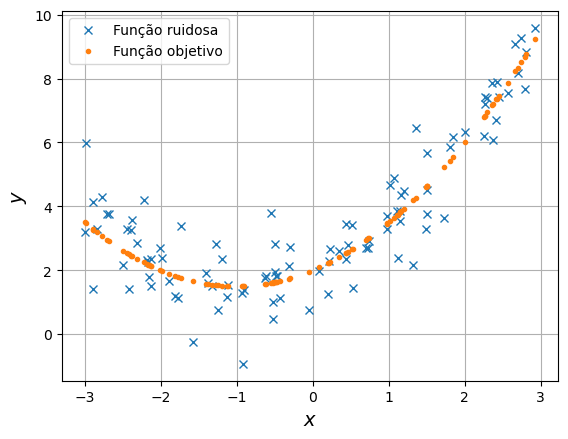

In [4]:
# Plot original data versus noisy version.
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
plt.plot(x, y, '.', label='Função objetivo')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
# Show the plot.
plt.show()

## Validação cruzada Holdout (70/30%)

O holdout pode ser implementado através da função `train_test_split`, onde passamos o tamanho, em porcentagem, do conjunto de validação (ou teste) através do parâmetro `test_size`.

In [5]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Split the whole dataset into random training and validation set.
x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=0.3, random_state=seed)

# Print size of the datasets.
print('Tamanho do conjunto de treinamento:', len(y_train))
print('Tamanho do conjunto de validação:', len(y_val))

Tamanho do conjunto de treinamento: 70
Tamanho do conjunto de validação: 30


In [6]:
# Define the orders to be tested.
poly_orders = range(1, 31)

# Lists used to keep training and validation MSE.
mse_train_vec = []
mse_val_vec = []

# Iterate over the specified degrees.
for d in poly_orders:
    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Train the model.
    poly_reg.fit(x_train, y_train)
    
    # Predict with the training dataset.
    y_train_predict = poly_reg.predict(x_train)
    
    # Predict with the validation dataset.
    y_val_predict = poly_reg.predict(x_val)
    
    # Calculate and store the MSE for the validation dataset into an array.
    mse_val_vec.append(mean_squared_error(y_val, y_val_predict))
    
    # Calculate and store the MSE for the training dataset into an array.
    mse_train_vec.append(mean_squared_error(y_train, y_train_predict))

holdout_time = timeit.default_timer() - starttime
print("Tempo de execução do holdout: %1.4f [s]" % (holdout_time))

Tempo de execução do holdout: 0.0848 [s]


## Comparando os erros de treinamento e validação para diversas ordens de polinômio.

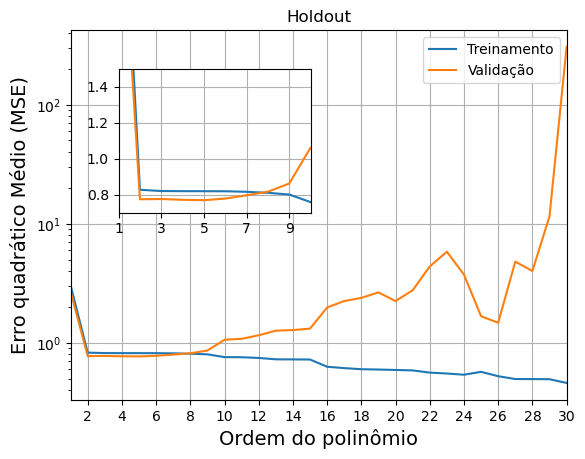

In [7]:
# Plot results.
fig = plt.figure()
plt.plot(poly_orders, mse_train_vec,  label='Treinamento')
plt.plot(poly_orders, mse_val_vec,  label='Validação')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Erro quadrático Médio (MSE)', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.yscale('log')
plt.title('Holdout')
plt.legend()
plt.grid()

left, bottom, width, height = [0.2, 0.5, 0.3, 0.3]
ax1 = fig.add_axes([left, bottom, width, height])
ax1.plot(poly_orders, mse_train_vec,  label='Treinamento')
ax1.plot(poly_orders, mse_val_vec,  label='Validação')
ax1.set_xlim(1, 10)
ax1.set_ylim(0.7, 1.5)
ax1.set_xticks(range(1,11,2))
ax1.grid()

#Show the plot.
plt.show()

+ Tempo médio para execução com N = 100 é de aproximadamente 120 ms.


+ Ambos os erros iniciam com valores altos ($\to$ subajuste).
    + A função hipótese polinômial não tem flexibilidade o suficiente para capturar o comportamento da função objetivo e, portanto, erra para os dados de ambos os conjuntos.


+ Com o aumento da ordem do polinômio, ambos decrescem até uma região onde ambos são mínimos.
    + A função hipótese polinômial tem a flexibilidade necessária para capturar o comportamento da função objetivo e, portanto, tem boa capacidade de generalização.


+ Na sequência, ocorre a divergência entre os erros ($\to$ sobreajuste):

    + Erro de treinamento **diminui** conforme a ordem do polinômio aumenta. 

    + Erro de validação **aumenta** conforme a ordem do polinômio aumenta.


+ Qual ordem escolher?

    * O ponto onde ambos os erros sejam mínimos (balanço entre flexibilidade e grau de generalização) e com menor complexidade.

## Validação cruzada: k-fold (k=10)

+ **$k = 10$** folds (ou subconjuntos): 10 pares de treinamento e validação, onde para cada par temos:
    + 9 subconjuntos para treinamento e 1 para validação do modelo.


+ O **$k$-fold** é implementado pela classe `KFold`, onde o parâmetro `n_splits` é usado para configurar o número de *folds*, $k$.


+ Um objeto desta classe se encarrega de embaralhar (opcional) e dividir o conjunto total de dados em $k$ subconjuntos.
    + Ela fornece os índices de início e fim dos conjuntos de treinamento e validação para cada um dos $k$ treinamentos e validações.


<img src="../../figures/kfold.jpg" width="500px">


+ Para realizar os treinamentos e validações, usamos a função `cross_val_score`, a qual automatiza os $k$ **pares** de treinamento e validação usando o objeto da classe `KFold` passado para ela.


+ Essa função retorna uma array NumPy (um vetor) com $k$ **pontuações** (`neg_mean_squared_error`), ou seja, uma pontuação para cada par de conjuntos de treinamento e validação.


+ Por ser uma função que calcula **pontuações**, ela retorna valores que quanto maiores, melhor é o modelo sendo avaliado. 


+ Porém, o **erro quadrático médio** (MSE) retorna valores que quanto menores, melhor é o modelo sendo avaliado. 
    + Lembrem-se que teoricamente queremos um erro o mais próximo de zero possível.


+ Por isso a multiplicação por $-1$ do valor do MSE. Ela transforma o MSE em uma pontuação, pois quanto mais próximo de zero o valor retornado, melhor será o modelo.

In [8]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the k-Fold object.
# Determines the cross-validation splitting strategy.
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Define the orders to be tested.
poly_orders = range(1, 31)

# Iterate over the specified degrees.
kfold_mean_vec = []
kfold_std_vec = []
for d in poly_orders:
    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Calculate the cross-validation score with kfold object.
    # OBS.: All scorer objects follow the convention that higher return values are better than lower return values. 
    #       Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, 
    #       are available as neg_mean_squared_error which return the negated value of the metric.
    lin_scores = cross_val_score(poly_reg, x, y_noisy, scoring='neg_mean_squared_error', cv=kfold)

    # Converte os scores de volta em valores de MSE.
    scores = -lin_scores
    # Calcula a média dos k erros (MSE) cometidos para os k conjuntos de validação. 
    kfold_mean_vec.append(scores.mean())
    # Calcula o desvio padrão dos k erros (MSE) cometidos para os k conjuntos de validação.
    kfold_std_vec.append(scores.std())

kfold_time = timeit.default_timer() - starttime
print("Tempo de execução do k-Fold: %1.4f [s]" % (kfold_time))

Tempo de execução do k-Fold: 0.6585 [s]


**OBS**.: Tempo médio para execução com $N = 100$ exemplos e $k = 10$ é de aproximadamente $0.66$ [s].

As figuras abaixo apresentam 

+ A média dos $k$ valores de erro quadrático médio de validação para cada uma das ordens testadas.


+ O desvio padrão para cada uma das ordens testadas.

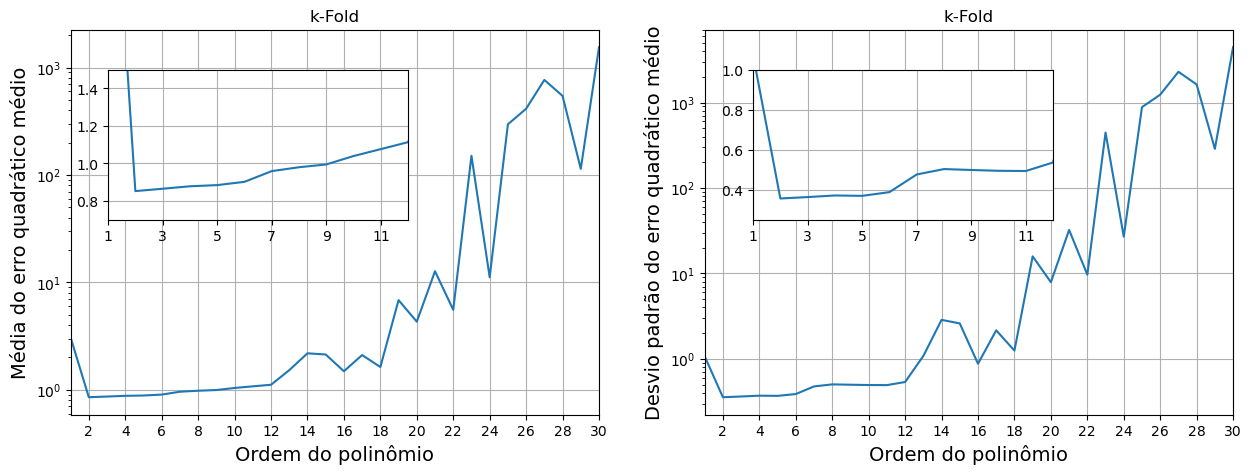

In [9]:
# Plot results.
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(poly_orders, kfold_mean_vec, label='Erro quadrático médio')
plt.yscale('log')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do erro quadrático médio', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.grid()
plt.title('k-Fold')

left, bottom, width, height = [0.15, 0.5, 0.2, 0.3]
ax1 = fig.add_axes([left, bottom, width, height])
ax1.plot(poly_orders, kfold_mean_vec)
ax1.set_xlim(1, 12)
ax1.set_ylim(0.7, 1.5)
ax1.set_xticks(range(1,13,2))
ax1.grid()

ax = plt.subplot(1, 2, 2)
plt.title('k-Fold')
plt.plot(poly_orders, kfold_std_vec, label='Desvio padrão do erro')
plt.yscale('log')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão do erro quadrático médio', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.grid()

left, bottom, width, height = [0.58, 0.5, 0.2, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(poly_orders, kfold_std_vec)
ax2.set_xlim(1, 12)
ax2.set_ylim(0.25, 1.0)
ax2.set_xticks(range(1,13,2))
ax2.grid()

# Save figure
#plt.savefig("kfold.png", dpi=600)
#Show the plot.
plt.show()

+ Os gráficos mostram a média e o desvio padrão do **MSE de validação** das 10 etapas de treinamento/validação.
+ Média e desvio padrão iniciam com valores altos ($\to$ subajuste).
+ Com o aumento da ordem do polinômio, ambos decrescem, atingindo o valor mais baixo de MSE para uma ordem igual a $2$.
+ Porém, conforme a ordem do polinômio continua a aumentar, a média e o desvio padrão do MSE começam a aumentar ($\to$ sobreajuste).
+ Qual ordem escolher?
    * O ponto onde ambos, média e desvio padrão do MSE de validação, sejam mínimos.


+ Se comparado com o MSE do holdout, a indicação de qual ordem usar é mais clara com o k-fold.

## Validação cruzada: Leave-p-out (p=2)


+ Com **$p = 2$** temos $4950$ combinações possíveis de 2 amostras para um conjunto com 100 amostras.


+ Isso significa que teremos $4950$ **pares de conjuntos de treinamento e validação**, ou seja, $4950$ treinamentos e validações.
    + Cada conjunto de treinamento possui $98$ amostras
    + Cada conjunto de validação possui $2$ amostras.



+ O **leave-p-out** é implementado pela classe `LeavePOut`, onde o parâmetro `p` configura o número de amostras **deixadas de lado** para a validação.


+ Um objeto desta classe divide o conjunto total de dados em $4950$ pares de conjuntos treinamento e validação.
    + Ela fornece os índices de início e fim dos conjuntos de treinamento e validação para cada um dos $4950$ treinamentos e validações.


+ Para realizar os treinamentos e validações, usamos novamente a função `cross_val_score` a qual automatiza os $4950$ **pares** de treinamento e validação usando o objeto da classe `LeavePOut` passado para ela.


+ A classe `LeavePOut` não tem a opção de embaralhar as amostras pois usa todas as combinações possíveis de `p` amostras do conjunto e `N` amostras.

In [10]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the LPOCV object.
# Determines the cross-validation splitting strategy.
# With p = 2 with have 4950 pairs of training and validation datasets. 
# That is, we have 4950 training/validation processes, where the validation
# set has 2 samples each.
lpocv = LeavePOut(p=2)

lpo_mean_vec = []
lpo_std_vec = []
# Iterate over the specified degrees.
poly_orders = range(1, 31)
for d in poly_orders:
    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Calculate the cross-validation score with LPO object.
    # OBS.: All scorer objects follow the convention that higher return values are better than lower return values. 
    #       Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, 
    #       are available as neg_mean_squared_error which return the negated value of the metric.
    lin_scores = cross_val_score(poly_reg, x, y_noisy, scoring='neg_mean_squared_error', cv=lpocv)
        
    scores = -lin_scores    
    # Calcula a média dos 4950 erros (MSE) cometidos para os 4950 conjuntos de validação. 
    lpo_mean_vec.append(scores.mean())
    # Calcula o desvio padrão dos 4950 erros (MSE) cometidos para os 4950 conjuntos de validação.   
    lpo_std_vec.append(scores.std())
    
lpo_time = timeit.default_timer() - starttime
print("Tempo de execução do leave-p-out: %1.4f [s]" % (lpo_time))

Tempo de execução do leave-p-out: 296.8323 [s]


**OBS**.: Tempo médio para execução com $N = 100$ e $p = 2$ é de aproximadamente 297 [s] ($\approx$ 5 [m]).

As figuras abaixo apresentam 

+ A média dos 4950 valores de MSE de validação para cada uma das ordens testadas.


+ O desvio padrão do MSE para cada uma das ordens testadas.

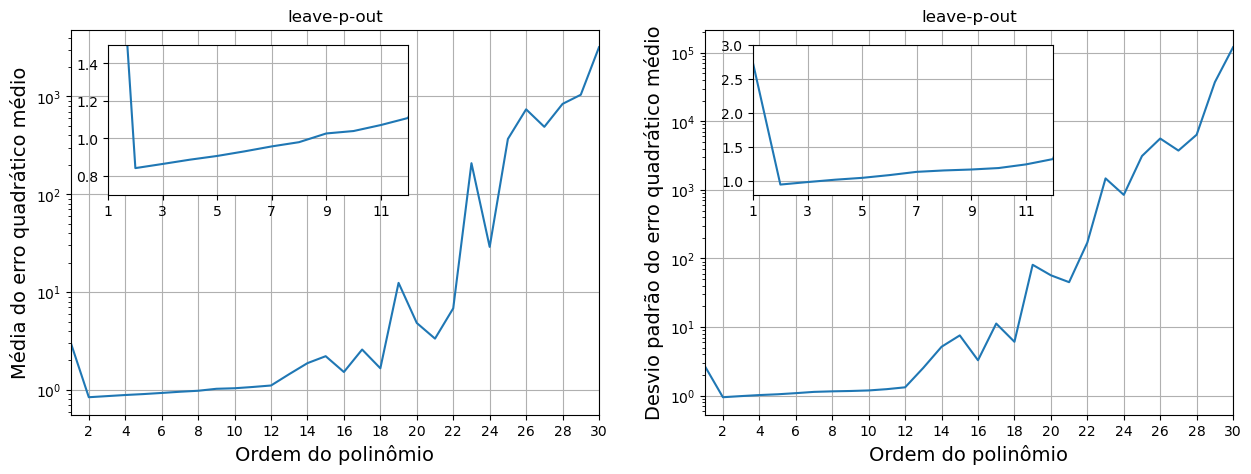

In [11]:
# Plot results.
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(poly_orders, lpo_mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do erro quadrático médio', fontsize=14)
plt.yscale('log')
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.grid()
plt.title('leave-p-out')

left, bottom, width, height = [0.15, 0.55, 0.2, 0.3]
ax1 = fig.add_axes([left, bottom, width, height])
ax1.plot(poly_orders, lpo_mean_vec)
ax1.set_xlim(1, 12)
ax1.set_ylim(0.7, 1.5)
ax1.set_xticks(range(1,13,2))
ax1.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(poly_orders, lpo_std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão do erro quadrático médio', fontsize=14)
plt.yscale('log')
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.grid()
plt.title('leave-p-out')

left, bottom, width, height = [0.58, 0.55, 0.2, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(poly_orders, lpo_std_vec)
ax2.set_xlim(1, 12)
ax2.set_ylim(0.8, 3)
ax2.set_xticks(range(1,13,2))
ax2.grid()

# Save figure
#plt.savefig("leave_p_out.png", dpi=600)
#Show the plot.
plt.show()

+ Gráficos mostram a média e o desvio padrão do **MSE de validação** para as 4950 etapas de treinamento de cada ordem testada.
+ Média e desvio padrão iniciam com valores altos ($\to$ subajuste).
+ Com o aumento da ordem do polinômio, ambos decrescem, atingindo o menor valor de MSE para uma ordem igual a 2.
+ Porém, conforme a ordem do polinômio continua a aumentar, a média e o desvio padrão do MSE começam a aumentar ($\to$ sobreajuste).
+ Qual ordem escolher?
    * O ponto onde ambos, média e desvio padrão do MSE, sejam mínimos.
    
+ A indicação de qual ordem usar é muito mais clara que nos casos anteriores, pois temos muito mais pares de treinamento e validação.

## Comparação do modelo gerador contra sua versão ruidosa e o modelo de regressão polinomial

### Melhor ordem: 2

Agora, de posse da melhor ordem para aproximar os dados, treinamos um novo modelo de regressão polinomial considerando esta ordem, calculamos o erro quadrático médio (MSE) e comparamos a predição feita pelo melhor regressor polinomial com os dados originais.

MSE: 0.7902604822991763


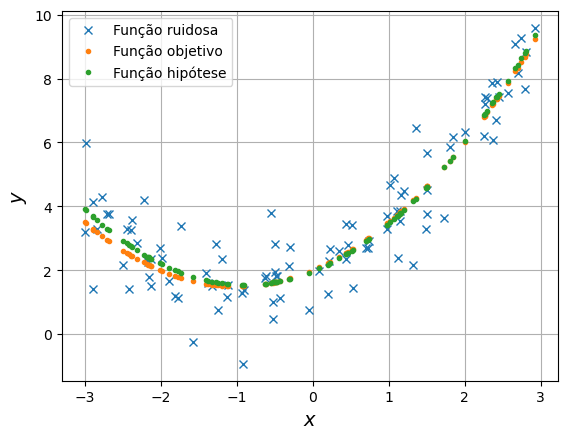

In [12]:
# Instantiate a polynomial.
poly = PolynomialFeatures(degree=2)
# Instantiate a scaler.
scaler = StandardScaler()
# Instantiate a linear regressor.
reg = LinearRegression()

# Create a pipeline of actions.
poly_reg = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Train the model with the ideal order.
poly_reg.fit(x, y_noisy)

# Predict using the trained model.
y_pred = poly_reg.predict(x)

mse = mean_squared_error(y_noisy, y_pred)
print('MSE:', mse)

# Plot original data versus noisy version and predicted version.
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
plt.plot(x, y, '.', label='Função objetivo')
plt.plot(x, y_pred, '.', label='Função hipótese')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
# Show the plot.
plt.show()